# Test out other models

In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, SCORERS
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, tree
import xgboost
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np

/Users/shiehan/anaconda3/envs/metis/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def save(clf, name):
    pickle_out = open(name,"wb")
    pickle.dump(clf, pickle_out)
    pickle_out.close()
    print ('Model ',name,' saved')


def load(clf_file):
    pickle_in = open(clf_file,"rb")
    clf = pickle.load(pickle_in)
    return clf

In [3]:
data = load('/Users/shiehan/Desktop/kaplan stuff/project5/data1.pkl')

In [4]:
X = data.drop(['Q6'], axis = 1)
y = data['Q6']
seed = 123
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [5]:
scaler = StandardScaler()
xtrain_val_scaled = scaler.fit_transform(X_train_val)
xtest_scaled = scaler.transform(X_test)

In [6]:
# these are the models I am testing out
classifiers = []
model1 = xgboost.XGBClassifier()
classifiers.append(model1)
model2 = svm.SVC()
classifiers.append(model2)
model3 = AdaBoostClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)
model5 = lgb.LGBMClassifier()
classifiers.append(model5)

In [7]:
for model in classifiers:
    model.fit(xtrain_val_scaled, y_train_val)
    y_pred= model.predict(xtest_scaled)
    f1 = f1_score(y_test, y_pred, average= 'micro')
    print("F1_micro of %s is %s"%(model, f1))

    cm = confusion_matrix(y_test, y_pred)
    #print("Confusion Matrix of %s is %s"%(model, cm))

F1_micro of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) is 0.7981981981981981
F1_micro of SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) is 0.8000000000000002
F1_micro of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) is 0.6720720720720721
F1_micro of RandomForestClassifier(bootstrap

In [8]:
# Parameters tuning with SVC!
nfolds = 5
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    random_search = RandomizedSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds, n_iter=100,scoring='f1_micro', verbose=2,random_state = seed, n_jobs=-1)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search.best_params_

In [9]:
print(svc_param_selection(xtrain_val_scaled, y_train_val, nfolds))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/shiehan/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s


{'gamma': 0.01, 'C': 10}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.4s finished


In [10]:
# SVM cross val with the best param
from sklearn.model_selection import cross_validate
svm_model = svm.SVC(kernel='rbf',gamma = 0.01, C = 10)
scores = cross_validate(svm_model, xtrain_val_scaled, y_train_val, cv=5, scoring='f1_micro')
scores

{'fit_time': array([0.13363695, 0.11898088, 0.1173799 , 0.12346196, 0.12156391]),
 'score_time': array([0.01995587, 0.01740789, 0.01693702, 0.01722503, 0.01722503]),
 'test_score': array([0.79504505, 0.75675676, 0.74040632, 0.751693  , 0.76072235])}

In [11]:
print('f1_micro:',scores['test_score'].mean())


f1_micro: 0.7609246944461392


In [12]:
svm_model.fit(xtrain_val_scaled,y_train_val)
svm_pred = svm_model.predict(xtest_scaled)
print('f1_micro:',f1_score(y_test, svm_pred, average= 'micro'))


f1_micro: 0.7963963963963963


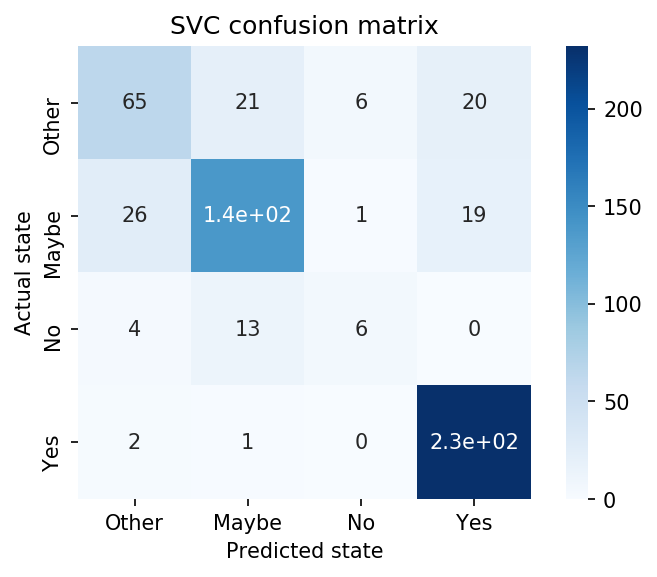

In [16]:
# print confusion matrix for SVC
logit_confusion = confusion_matrix(y_test, svm_model.predict(xtest_scaled))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=data['Q6'].unique(),
           yticklabels=data['Q6'].unique())

plt.xlabel('Predicted state')
plt.ylabel('Actual state')
plt.title('SVC confusion matrix');

#plt.savefig("confusion_matrix_logit_data_IV")

In [14]:
# XGBClassifier param tuning!
def XGB_param_selection(X, y, nfolds):
    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] 
    max_depth = [3, 4, 5, 6, 8, 10, 12, 15]
    min_child_weight = [1, 3, 5, 7]
    gamma = [0.0, 0.1, 0.2 , 0.3, 0.4]
    colsample_bytree = [0.3, 0.4, 0.5 , 0.7]
    param_grid = {'learning_rate': learning_rate, 'max_depth' : max_depth, 'min_child_weight': min_child_weight, 'gamma':gamma, 'colsample_bytree': colsample_bytree}
    random_search = RandomizedSearchCV(xgboost.XGBClassifier(objective='multi:softmax'), param_grid, cv=nfolds, n_iter=100,scoring='f1_micro', verbose=2,random_state = seed, n_jobs=-1)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search.best_params_

In [15]:
print(XGB_param_selection(xtrain_val_scaled, y_train_val, nfolds))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.3s


KeyboardInterrupt: 

In [ ]:
# XGBClassifier cross val with the best param

xgb_model = xgboost.XGBClassifier(objective='multi:softmax', min_child_weight= 7, max_depth= 3, learning_rate= 0.1, gamma= 0.4, colsample_bytree= 0.3)
scores = cross_validate(xgb_model, xtrain_val_scaled, y_train_val, cv=5, scoring='f1_micro')
scores

In [ ]:
print('f1_micro:',scores['test_score'].mean())

In [ ]:
xgb_model.fit(xtrain_val_scaled,y_train_val)
xgb_pred = xgb_model.predict(xtest_scaled)
print('f1_micro:',f1_score(y_test, xgb_pred, average= 'micro'))


In [ ]:
# LGB param tuning!
def lgb_param_selection(X, y, nfolds):
    bagging_fraction =  [0.5, 0.8]
    bagging_frequency = [5, 8]
    feature_fraction = [0.5, 0.8]
    max_depth = [10, 13]
    min_data_in_leaf = [90, 120]
    num_leaves = [1200, 1550]
    param_grid = {'bagging_fraction': bagging_fraction, 'bagging_frequency' : bagging_frequency, 
                  'feature_fraction':feature_fraction, 'max_depth':max_depth, 'min_data_in_leaf':min_data_in_leaf,
                 'num_leaves':num_leaves}
    random_search = RandomizedSearchCV(lgb.LGBMClassifier(objective = 'multiclass'), param_grid, cv=nfolds, n_iter=100,scoring='f1_micro', verbose=2,random_state = seed, n_jobs=-1)
    random_search.fit(X, y)
    random_search.best_params_
    return random_search.best_params_

In [ ]:
print(lgb_param_selection(xtrain_val_scaled, y_train_val, nfolds))

In [ ]:
# LGBMClassifier cross val with the best params
lgbm_model = lgb.LGBMClassifier(objective = 'multiclass',num_leaves= 1200, min_data_in_leaf = 120, max_depth= 10, feature_fraction= 0.8, bagging_frequency= 5, bagging_fraction= 0.5)
scores = cross_validate(lgbm_model, xtrain_val_scaled, y_train_val, cv=5, scoring='f1_micro')
scores

In [ ]:
print('f1_micro:',scores['test_score'].mean())

In [ ]:
lgbm_model.fit(xtrain_val_scaled,y_train_val)
lgbm_pred = lgbm_model.predict(xtest_scaled)
print('f1_micro:',f1_score(y_test, lgbm_pred, average= 'micro'))

In [ ]:
rf = RandomForestClassifier(random_state = seed)
rf.fit(xtrain_val_scaled, y_train_val)

In [ ]:
# Build a forest and compute the feature importances

features = data.drop(['Q6'],axis=1).columns
importances = rf.feature_importances_
importance_lst = list(zip(features,importances))
# Print the feature ranking
print("Feature ranking:")

indices = np.argsort(importances)
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#52B2BF', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

